# 1 Import Library

In [1]:
%reset -f

In [2]:
import plotting
from pyseis.wave_equations import elastic_isotropic, acoustic_isotropic
from pyseis.wavelets.elastic import Elastic2D
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, interpolate

import os
import math
pwd = os.getcwd()
%env DATAPATH={pwd}/wrk/

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files
env: DATAPATH=/home/test01/App/01_PySeis/xu/TASK6_DAS_DATA/Data/FWI/wrk/


# 2 Read Model

In [3]:
dir_model = "./model/"
dir_seis  = "./seis/"
ox, oz = 0.0, 0.0
dx, dz = 1.0, 1.0
x1, x2 = 0.0, 550.0
z1, z2 = 0.0, 900.0


x_grid = np.arange(x1, x2 + dx, dx)
z_grid = np.arange(z1, z2 + dz, dz)
nx, nz = x_grid.size, z_grid.size
print("Grid dimensions: ", nx, nz)
model_sampling = (dx, dz)

model_padding = (100,100)
### Read (dx, dz) = (2, 2) model
vp2d_true = np.fromfile(dir_model+"vp2d_true.bin", dtype="float32")
vp2d_init = np.fromfile(dir_model+"vp2d_init.bin", dtype="float32")

vp2d_true = vp2d_true.reshape(nx,nz)
vp2d_init = vp2d_init.reshape(nx,nz)

Grid dimensions:  551 901


In [4]:
# ---- Receiver geometry ----
drec = 1.0
recz1 = 1.0
recz2 =884
recx1 = 200.0
recz = np.arange(recz1, recz2, drec)
recx = np.full(recz.shape, recx1)
recs = np.column_stack([recx, recz])

# ---- Source geometry ----
srcx = np.array([182.3])
srcz = np.full(srcx.shape, 1.0)
srcs = np.column_stack([srcx, srcz])


# Sampling in the x and z directions (5m for both in this case)
model_sampling = (dx, dz)
# Origin of the model (0, 0)
model_origins = (ox, oz)



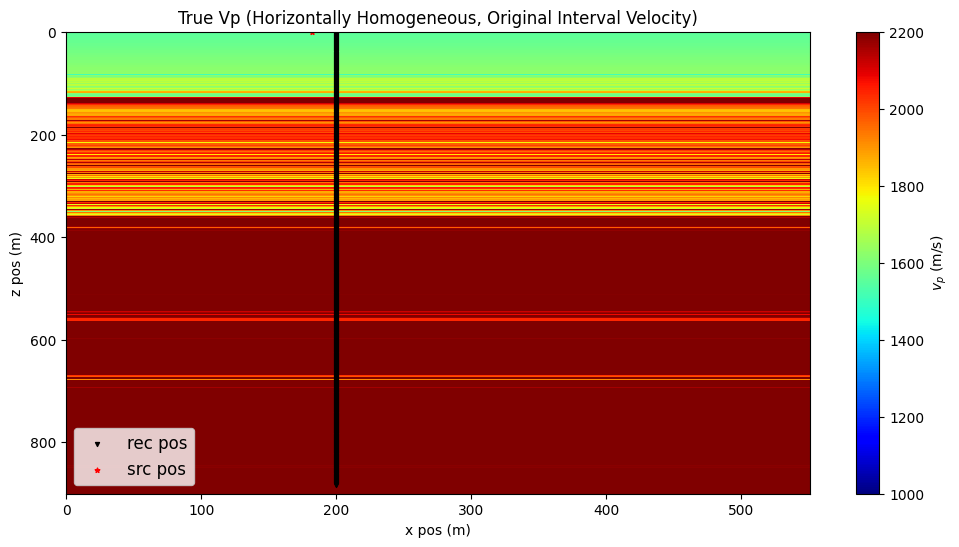

In [5]:
# ---- Plot ----
plotting.plot_model(
    vp2d_true,
    title="True Vp (Horizontally Homogeneous, Original Interval Velocity)",
    cbar=True,
    sampling=(dx, dz),
    origins=(ox, oz),
    cmap='jet',
    cbar_label='$v_p$ (m/s)',
    src_locations=srcs,
    rec_locations=recs,
    figsize=(12, 6),
    vlims=[1000, 2200]
)



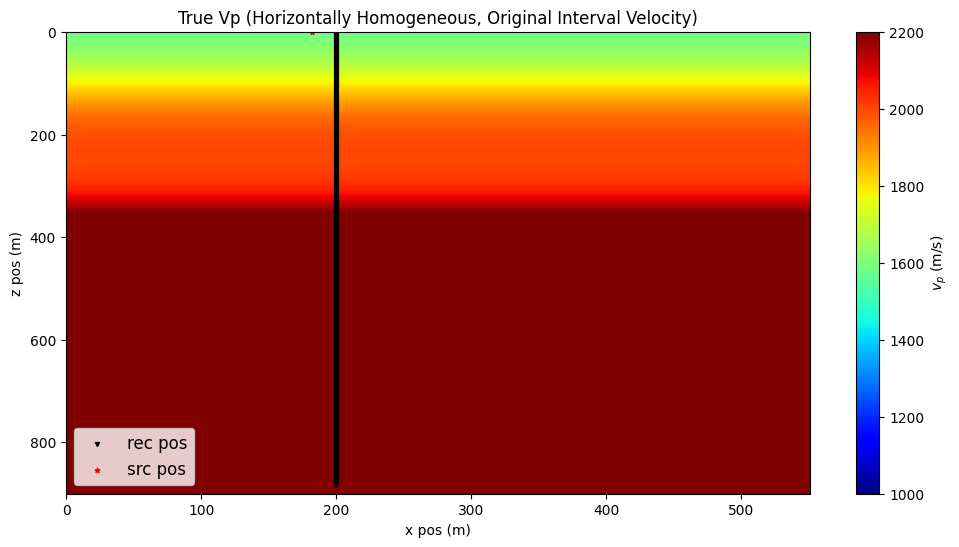

In [6]:
plotting.plot_model(
    vp2d_init,
    title="True Vp (Horizontally Homogeneous, Original Interval Velocity)",
    cbar=True,
    sampling=(dx, dz),
    origins=(ox, oz),
    cmap='jet',
    cbar_label='$v_p$ (m/s)',
    src_locations=srcs,
    rec_locations=recs,
    figsize=(12, 6),
    vlims=[1000, 2200]
)

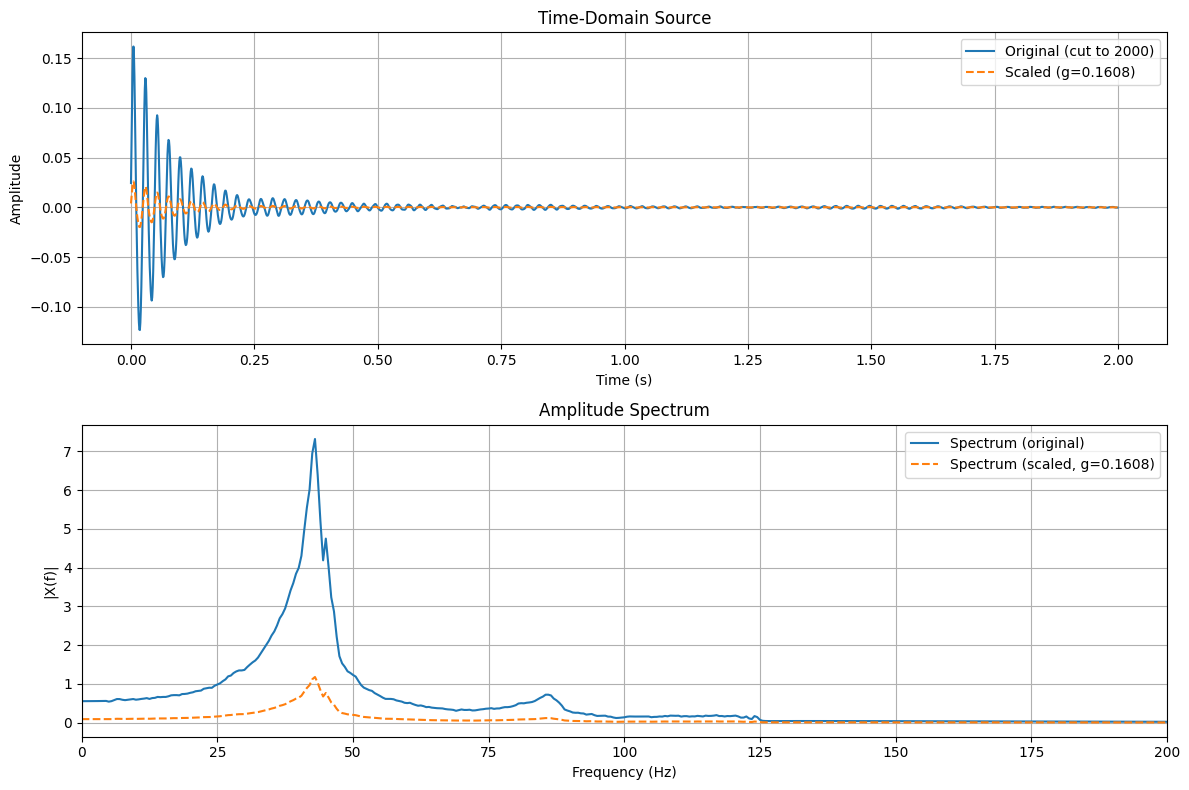

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -------- params --------
file_path1 = "source_pilot_run3_raw.bin"
nt = 3001       # original samples
dt = 0.001
nt_new = 2000   # cut down to 2000 samples

# -------- load raw --------
data1 = np.fromfile(file_path1, dtype=np.float32).astype(np.float64, copy=False)
if len(data1) < nt:
    raise ValueError(f"File has {len(data1)} samples, but nt={nt} requested.")
data1_raw = data1[:nt_new]   # keep only 2000 samples

# time axis
time_axis = np.arange(nt_new) * dt

# -------- scale --------
g = 0.1608
new_source = data1_raw.copy()        # original cut
scaled_source = g * data1_raw        # scaled version

# -------- spectrum helper --------
def one_sided_spectrum(x, dt):
    X = np.fft.rfft(x)
    f = np.fft.rfftfreq(len(x), d=dt)
    return f, np.abs(X)

f_src_raw, A_src_raw = one_sided_spectrum(new_source, dt)
f_src_scaled, A_src_scaled = one_sided_spectrum(scaled_source, dt)


source_form = np.pad(data1_raw, (0, nt_new - len(data1_raw)), mode="constant")

source_form_scale = g * np.pad(data1_raw, (0, nt_new - len(data1_raw)), mode="constant")



# -------- plots --------
plt.figure(figsize=(12, 8))

# Time-domain (cut + scaled)
plt.subplot(2, 1, 1)
plt.plot(time_axis, new_source, label='Original (cut to 2000)')
plt.plot(time_axis, scaled_source, label=f'Scaled (g={g})', linestyle='--')
plt.title("Time-Domain Source")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
plt.grid(True); plt.legend()

# Spectrum (raw vs scaled)
plt.subplot(2, 1, 2)
plt.plot(f_src_raw, A_src_raw, label='Spectrum (original)')
plt.plot(f_src_scaled, A_src_scaled, label=f'Spectrum (scaled, g={g})', linestyle='--')
plt.title("Amplitude Spectrum")
plt.xlabel("Frequency (Hz)"); plt.ylabel("|X(f)|")
plt.xlim(0, 200); plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# make 2d elastic wave equation solver
acoustic_2d_obs_base = acoustic_isotropic.AcousticIsotropic2D(
    model=vp2d_true,
    model_sampling=model_sampling,
    model_padding=model_padding,
    wavelet=source_form_scale,
    d_t=dt,
    src_locations=srcs,
    rec_locations=recs,
    model_origins=model_origins,
    subsampling=40,
    gpus=[0])

In [9]:
%%time
data_obs_base_p = acoustic_2d_obs_base.forward(vp2d_true)

CPU times: user 9.11 s, sys: 3.31 s, total: 12.4 s
Wall time: 4.29 s


In [10]:
%%time
data_cal_base_p = acoustic_2d_obs_base.forward(vp2d_init)

CPU times: user 7.48 s, sys: 2.85 s, total: 10.3 s
Wall time: 4.11 s


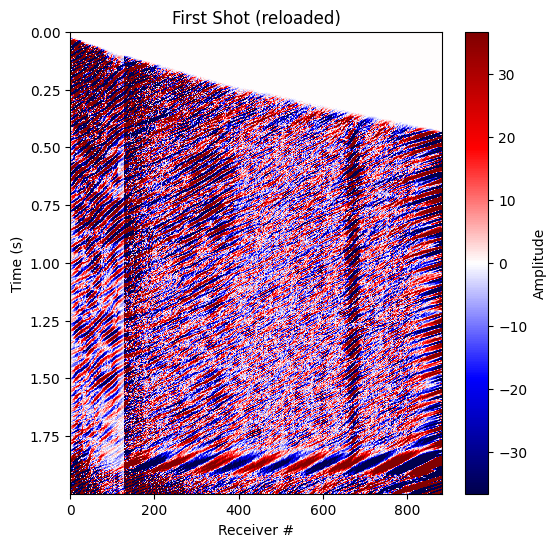

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# dimensions
nr, nt = 883, 2000
dt = 0.001  # sample interval [s]

# reload the binary file
shot0 = np.fromfile("./data/input_upgoing_FB_neartrace_decon.bin", dtype=np.float32).reshape(nr, nt)

# build axes
time_axis = np.arange(nt) * dt
rec_axis = np.arange(nr)

# robust scaling for colormap
vmax = np.percentile(np.abs(shot0), 85)   # you can adjust 85 -> 90/95
vmin = -vmax

# plot
plt.figure(figsize=(6, 6))
plt.pcolormesh(rec_axis, time_axis, shot0.T,
               shading='nearest', cmap='seismic',
               vmin=vmin, vmax=vmax)
plt.gca().invert_yaxis()
plt.title("First Shot (reloaded)")
plt.xlabel("Receiver #")
plt.ylabel("Time (s)")
plt.colorbar(label="Amplitude")
plt.show()




In [12]:
# extend to 3D to fit with RTM process
shot0_cut_3d = shot0[np.newaxis, :, :]   # (1, 446, 2000)

# Amplitude Mismatch Problem

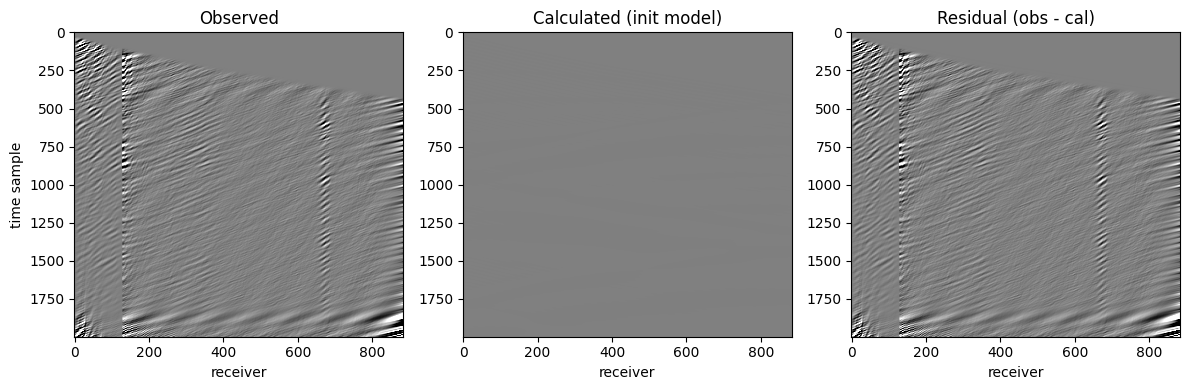

In [13]:
obs = np.squeeze(shot0_cut_3d)   # (446, 2000)
cal = np.squeeze(data_cal_base_p)   # (446, 2000)
res = obs - cal

vmax = np.percentile(np.abs(obs), 99)  # consistent scaling

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(obs.T, aspect='auto', cmap='gray', vmin=-vmax, vmax=vmax)
plt.title("Observed"); plt.xlabel("receiver"); plt.ylabel("time sample")

plt.subplot(1,3,2)
plt.imshow(cal.T, aspect='auto', cmap='gray', vmin=-vmax, vmax=vmax)
plt.title("Calculated (init model)"); plt.xlabel("receiver")

plt.subplot(1,3,3)
plt.imshow(res.T, aspect='auto', cmap='gray', vmin=-vmax, vmax=vmax)
plt.title("Residual (obs - cal)"); plt.xlabel("receiver")

plt.tight_layout(); plt.show()


In [14]:
obs = np.squeeze(shot0_cut_3d)
cal = np.squeeze(data_cal_base_p)

# compute least-squares scale factor
scale = np.sum(obs * cal) / (np.sum(cal * cal) + 1e-12)

cal_scaled = scale * cal
print("Applied global scale:", scale)


Applied global scale: 94.78330813380337


# 5 FWI RUN

In [15]:
# afwi_test = inversion.Fwi(acoustic_2d_obs_base,
#                          shot0_cut_3d,
#                          vp2d_init,
#                          num_iter=2,
#                          solver_type='cg',
#                          stepper_type='parabolic',
#                          iterations_per_save=5,
#                          prefix='aFWI4d_flat_curved_p')

In [16]:
# %%time
# history = afwi_test.run()

In [17]:
vp2d_init.shape

(551, 901)

In [18]:
# plotting.plot_model(history['inv_mod'],
#                     title='Difference',
#                     cbar=True,
#                     sampling=model_sampling,
#                     origins=model_origins,
#                     cmap='seismic',
#                     src_locations=srcs,
#                     rec_locations=recs,
#                     figsize=(12,6),
#                     vlims=[1000,3500],
#                    )



In [19]:
# obj_func_original = history['obj']
# fig, ax = plt.subplots(1,figsize=(10,5))
# ax.plot(obj_func_original/obj_func_original.max(), label='original')
# _ = ax.set_xlabel('iterations')
# _ = ax.set_ylabel('norm objective function')
# ax.legend()
# ax.grid()

In [20]:
import numpy as np

vmin, vmax = 500.0, 6000.0
vp_curr = np.clip(vp2d_init, vmin, vmax)

N_outer = 20
for k in range(N_outer):
    afwi_step = inversion.Fwi(
        acoustic_2d_obs_base,
        shot0_cut_3d,                    # (1, 446, 2000)
        vp_curr,                  # (551, 901)
        num_iter=1,               # one CG step per outer loop
 #       solver_type='cg',
        solver_type='lbfgs',
        stepper_type='parabolic',
        iterations_per_save=1,
        prefix=f'aFWI4d_flat_curved_p_iter{k+1:02d}'
    )

    history = afwi_step.run()     # dict with keys: inv_mod, gradient, model, residual, obj

    # <-- Use inv_mod: correct shape for the solver
    vp_next = history["inv_mod"]            # (551, 901)
    vp_curr = np.clip(vp_next, vmin, vmax)  # enforce physical bounds

    # (optional) mild smoothing for stability
    # from scipy.ndimage import uniform_filter
    # vp_curr = uniform_filter(vp_curr, size=3)

    print(f"[Outer {k+1}/{N_outer}] vp range: {vp_curr.min():.1f}–{vp_curr.max():.1f} m/s")

vp2d_final = vp_curr


##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2025-09-19T04-33-01.591595/
##########################################################################################

iter = 0, obj = 1.91471e+09, resnorm = 6.19e+04, gradnorm = 2.70e-02, feval = 1, geval = 1
**** ERROR: Courant is too big: 7.56637 ****
Max velocity value: 302655
Dtw: 2.5e-05 [s]
Min (dz, dx): 1 [m]


RuntimeError: 

In [ ]:
plotting.plot_model(history['inv_mod'],
                    title='Difference',
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='seismic',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[1000,3500],
                   )

In [ ]:
plotting.plot_model(vp2d_final,
                    title='Difference',
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='seismic',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[1000,3500],
                   )

In [ ]:
plotting.plot_model(vp2d_init,
                    title='Difference',
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='seismic',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[1000,3500],
                   )


In [ ]:
plotting.plot_model(vp2d_final-vp2d_init,
                    title='Difference',
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='seismic',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[-20,20],
                    xlims=(100, 300)   # <<< restrict x-axis
)

In [ ]:
import numpy as np

# vp2d_final is your FWI velocity model (nz=551, nx=901)
vel = vp2d_final.astype(np.float32)

# save as raw binary file (z-fast layout, i.e. [z,x])
vel.tofile("vel_init_rtm.bin")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Choose x location (index, not meters)
x_location = 180  

# Extract 1D profiles
vp1d_base = vp2d_init[x_location, :]
vp1d_moni = vp2d_final[x_location, :]

# Depth axis
depth = np.linspace(model_origins[1],
                    model_origins[1] + model_sampling[1] * len(vp1d_base),
                    len(vp1d_base))

# Depth range
depth_min, depth_max = 0, 800
mask = (depth >= depth_min) & (depth <= depth_max)

vp1d_base = vp1d_base[mask]
vp1d_moni = vp1d_moni[mask]
depth = depth[mask]

# ---- single plot ----
plt.figure(figsize=(5,7))
plt.plot(vp1d_base, depth, label='Initial Vp', color='blue')
plt.plot(vp1d_moni, depth, label='FWI Vp', color='red', linestyle='--')
plt.gca().invert_yaxis()
plt.xlabel('$V_p$ (m/s)')
plt.ylabel('Depth (m)')
plt.title(f'Vp Comparison at x index {x_location}\nDepth {depth_min}-{depth_max} m')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
